In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
import pandas as pd
%matplotlib inline
np.random.seed(1)
import scipy.io
tf.disable_v2_behavior()
import os
import tensorflow_hub as hub
import cv2

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulmangalampalli","key":"dc82792107f47dd42e89291c402b8351"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d kmader/oxford-flower-segmentations

 98% 518M/529M [00:05<00:00, 58.1MB/s]
100% 529M/529M [00:05<00:00, 98.4MB/s]


In [0]:
import zipfile
with zipfile.ZipFile('/content/oxford-flower-segmentations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [0]:
import scipy.io
label = scipy.io.loadmat('/content/imagelabels.mat')
y = label['labels'][0]

In [0]:
train_id = scipy.io.loadmat('/content/setid.mat')['trnid'][0]
test_id = scipy.io.loadmat('/content/setid.mat')['valid'][0]

In [0]:
train_y = []
train = []
test_y = []
test = []

In [0]:
dir = '/content/segmim/segmim'
for i in train_id:
  if len(str(i)) == 1:
    path = 'segmim_0000'+str(i)+'.jpg'
  if len(str(i)) == 2:
    path = 'segmim_000'+str(i)+'.jpg'
  if len(str(i)) == 3:
    path = 'segmim_00'+str(i)+'.jpg'
  if len(str(i)) == 4:
    path = 'segmim_0'+str(i)+'.jpg'
  img = cv2.imread(os.path.join(dir, path))
  train_y.append(y[i-1])
  resized = cv2.resize(img,(299,299))
  norm = cv2.normalize(resized,None,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  train.append(norm)

In [0]:
for i in test_id:
  if len(str(i)) == 1:
    path = 'segmim_0000'+str(i)+'.jpg'
  if len(str(i)) == 2:
    path = 'segmim_000'+str(i)+'.jpg'
  if len(str(i)) == 3:
    path = 'segmim_00'+str(i)+'.jpg'
  if len(str(i)) == 4:
    path = 'segmim_0'+str(i)+'.jpg'
  
  img = cv2.imread(os.path.join(dir, path))
  test_y.append(y[i-1])
  resized = cv2.resize(img,(299,299))
  norm = cv2.normalize(resized,None,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  test.append(norm)

In [0]:
train,test = np.array(train),np.array(test)
train_y,test_y = np.array(train_y),np.array(test_y)
print(train.shape,test.shape)

(1020, 299, 299, 3) (1020, 299, 299, 3)


In [0]:
from sklearn.preprocessing import OneHotEncoder
train_y_ = OneHotEncoder().fit_transform(train_y.reshape(-1,1)).toarray()
test_y_ = OneHotEncoder().fit_transform(test_y.reshape(-1,1)).toarray()

y = 1


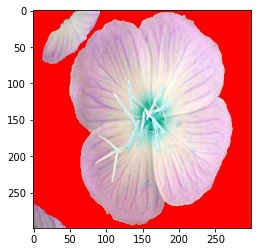

In [0]:
import matplotlib.pyplot as plt
index = 5
plt.imshow(test[index])
print("y = " + str((test_y[index])))

In [0]:
#from sklearn.model_selection import train_test_split

In [0]:
#X_train ,X_test ,Y_train, Y_test = train_test_split(X,Y_trans,test_size = 0.2, random_state = 10)

In [0]:
#X_train = X_train/255
#X_test = X_test/255

In [0]:
#X_train = X_train.reshape(len(X_train),150,150,3)
#X_test = X_test.reshape(len(X_test),150,150,3)

In [0]:
def batches(X_train,Y_train):
    X_train_set = []
    Y_train_set = []
    for i in range(len(X_train)//128):
        X_train_set.append(X_train[i*128:(i+1)*128,:,:,:])
        Y_train_set.append(Y_train[i*128:(i+1)*128,:])
    return X_train_set,Y_train_set    

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    return X, Y

In [0]:
def forward_propagation(X):
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1") #https://tfhub.dev/google/imagenet/inception_v3 for more details
    outputs = module(X)
    Z5 = tf.layers.dense(inputs=outputs, units=102)
    return Z5

In [0]:
def compute_cost(Z5, Y):

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z5, labels = Y))
  
    
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 100, print_cost = True):

    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    

    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    Z5 = forward_propagation(X)

    cost = compute_cost(Z5, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

    init = tf.global_variables_initializer()
     

    with tf.Session() as sess:

        sess.run(init)
        
        for epoch in range(num_epochs):

            minibatch_cost = 0
            X_set , Y_set = batches(X_train, Y_train)

            for x,y in zip(X_set,Y_set):

                minibatch_X, minibatch_Y = x,y

                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
  
                
                minibatch_cost += temp_cost / len(X_set)
                


            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()


        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        #os.mkdir('/model')
        #tf.saved_model.simple_save(sess, '/model', inputs={"X": X}, outputs={"Z5": Z5})
        print('--- MODEL SAVED ---')        
        return train_accuracy, test_accuracy

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Cost after epoch 0: 5.879155
Cost after epoch 5: 2.934431
Cost after epoch 10: 1.782900
Cost after epoch 15: 1.179945
Cost after epoch 20: 0.842709
Cost after epoch 25: 0.637094
Cost after epoch 30: 0.502994
Cost after epoch 35: 0.411101
Cost after epoch 40: 0.345742
Cost after epoch 45: 0.297855
Cost after epoch 50: 0.261892
Cost after epoch 55: 0.234303
Cost after epoch 60: 0.212736
Cost after epoch 65: 0.195585
Cost after epoch 70: 0.181732
Cost after epoch 75: 0.170381
Cost after epoch 80: 0.160957
Cost after epoch 85: 0.153041
Cost after epoch 90: 0.146319
Cost after epoch 95: 0.140557


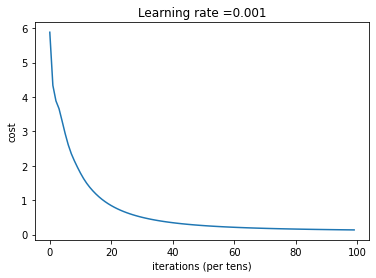

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8568627
Test Accuracy: 0.62352943
--- MODEL SAVED ---


In [0]:
_, _= model(train, train_y_, test, test_y_)